In [1]:
!nvidia-smi
!pip install ultralytics

Thu Apr 17 06:43:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import ultralytics
from ultralytics import YOLO
from IPython.display import Image
from kaggle_secrets import UserSecretsClient
import os

ultralytics.checks()

Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6281.6/8062.4 GB disk)


In [3]:
import yaml
import os
from pprint import pprint

# Path to the original YAML file
input_file_path = '/kaggle/input/smoke-fire-detection-yolo/data.yaml'

# Step 1: Read and display the original YAML file contents
print("Original YAML file contents:")
with open(input_file_path, 'r') as file:
    data = yaml.safe_load(file)
    pprint(data)

Original YAML file contents:
{'names': ['smoke', 'fire'],
 'nc': 2,
 'path': '/kaggle/working/D Fire Dataset',
 'test': 'data/test/images',
 'test_count': 4306,
 'train': 'data/train/images',
 'train_count': 14122,
 'val': 'data/val/images',
 'val_count': 3099}


In [4]:
import yaml

root="/kaggle/input/smoke-fire-detection-yolo"

yml_file_path = f"{root}/data.yaml"

with open(yml_file_path, 'r') as file: data = yaml.safe_load(file)

# Update the paths
data['train'] = f'{root}/data/train'
data['val']   = f'{root}/data/val'
data['test']  = f'{root}/data/test'

print(data)
# Save the updated YAML content to a file
output_path = '/kaggle/working/updated_config.yaml'
with open(output_path, 'w') as file: yaml.dump(data, file, default_flow_style=False)

{'path': '/kaggle/working/D Fire Dataset', 'train': '/kaggle/input/smoke-fire-detection-yolo/data/train', 'val': '/kaggle/input/smoke-fire-detection-yolo/data/val', 'test': '/kaggle/input/smoke-fire-detection-yolo/data/test', 'names': ['smoke', 'fire'], 'nc': 2, 'train_count': 14122, 'val_count': 3099, 'test_count': 4306}


In [5]:
import os
from collections import defaultdict

def read_yolo_annotations_with_metadata(dataset_metadata):
    # Extract paths and class names
    train_path = dataset_metadata['train'].replace('images', 'labels')
    val_path = dataset_metadata['val'].replace('images', 'labels')
    test_path = dataset_metadata['test'].replace('images', 'labels')
    class_names = dataset_metadata['names']
    
    # Storage variables
    split_stats = {
        'train': defaultdict(int),
        'val': defaultdict(int),
        'test': defaultdict(int)
    }

    def process_labels(label_dir, split_name):
        for label_file in os.listdir(label_dir):
            if not label_file.endswith(".txt"):
                continue

            label_path = os.path.join(label_dir, label_file)
            
            # Read annotations
            with open(label_path, 'r') as f:
                lines = [line.strip() for line in f.readlines() if line.strip()]
            
            # Find present classes
            present_classes = set()
            for line in lines:
                class_id = int(line.strip().split()[0])
                present_classes.add(class_id)
            
            # Update counts
            if 0 in present_classes and 1 in present_classes:
                split_stats[split_name]['both'] += 1
            elif 0 in present_classes:
                split_stats[split_name]['fire_only'] += 1
            elif 1 in present_classes:
                split_stats[split_name]['smoke_only'] += 1
            else:
                split_stats[split_name]['background'] += 1

    # Process all datasets
    process_labels(train_path, 'train')
    process_labels(val_path, 'val')
    process_labels(test_path, 'test')

    return {
        'class_stats': split_stats,
        'class_names': class_names
    }

# Example usage
dataset_metadata = {
    'names': ['Fire', 'Smoke'],
    'nc': 2,
    'test': '/kaggle/input/smoke-fire-detection-yolo/data/test/images',
    'train': '/kaggle/input/smoke-fire-detection-yolo/data/train/images',
    'val': '/kaggle/input/smoke-fire-detection-yolo/data/val/images'
}

results = read_yolo_annotations_with_metadata(dataset_metadata)

# Print the report
print("Fire/Smoke Distribution Across Splits:\n")
for split in ['train', 'val', 'test']:
    stats = results['class_stats'][split]
    total = sum(stats.values())
    print(f"{split.upper()} SET ({total} images)")
    print(f"- Fire only: {stats['fire_only']} ({stats['fire_only']/total:.1%})")
    print(f"- Smoke only: {stats['smoke_only']} ({stats['smoke_only']/total:.1%})")
    print(f"- Both present: {stats['both']} ({stats['both']/total:.1%})")
    print(f"- Background (neither): {stats['background']} ({stats['background']/total:.1%})")
    print()

Fire/Smoke Distribution Across Splits:

TRAIN SET (14122 images)
- Fire only: 3836 (27.2%)
- Smoke only: 770 (5.5%)
- Both present: 3058 (21.7%)
- Background (neither): 6458 (45.7%)

VAL SET (3099 images)
- Fire only: 845 (27.3%)
- Smoke only: 174 (5.6%)
- Both present: 705 (22.7%)
- Background (neither): 1375 (44.4%)

TEST SET (4306 images)
- Fire only: 1186 (27.5%)
- Smoke only: 220 (5.1%)
- Both present: 895 (20.8%)
- Background (neither): 2005 (46.6%)



In [ ]:
!yolo task=detect mode=train data={output_path} model="yolo11n.pt" epochs=200 imgsz=640 batch=0.7 patience=30

100%|██████████████████████████████████████| 5.35M/5.35M [00:00<00:00, 75.5MB/s]
Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/updated_config.yaml, epochs=200, time=None, patience=30, batch=0.7, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=

In [14]:
!yolo task=detect mode=train resume=true model="/kaggle/working/runs/detect/train/weights/last.pt" data={output_path}

Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/runs/detect/train/weights/last.pt, data=/kaggle/working/updated_config.yaml, epochs=200, time=None, patience=30, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=/kaggle/working/runs/detect/train/weights/last.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt

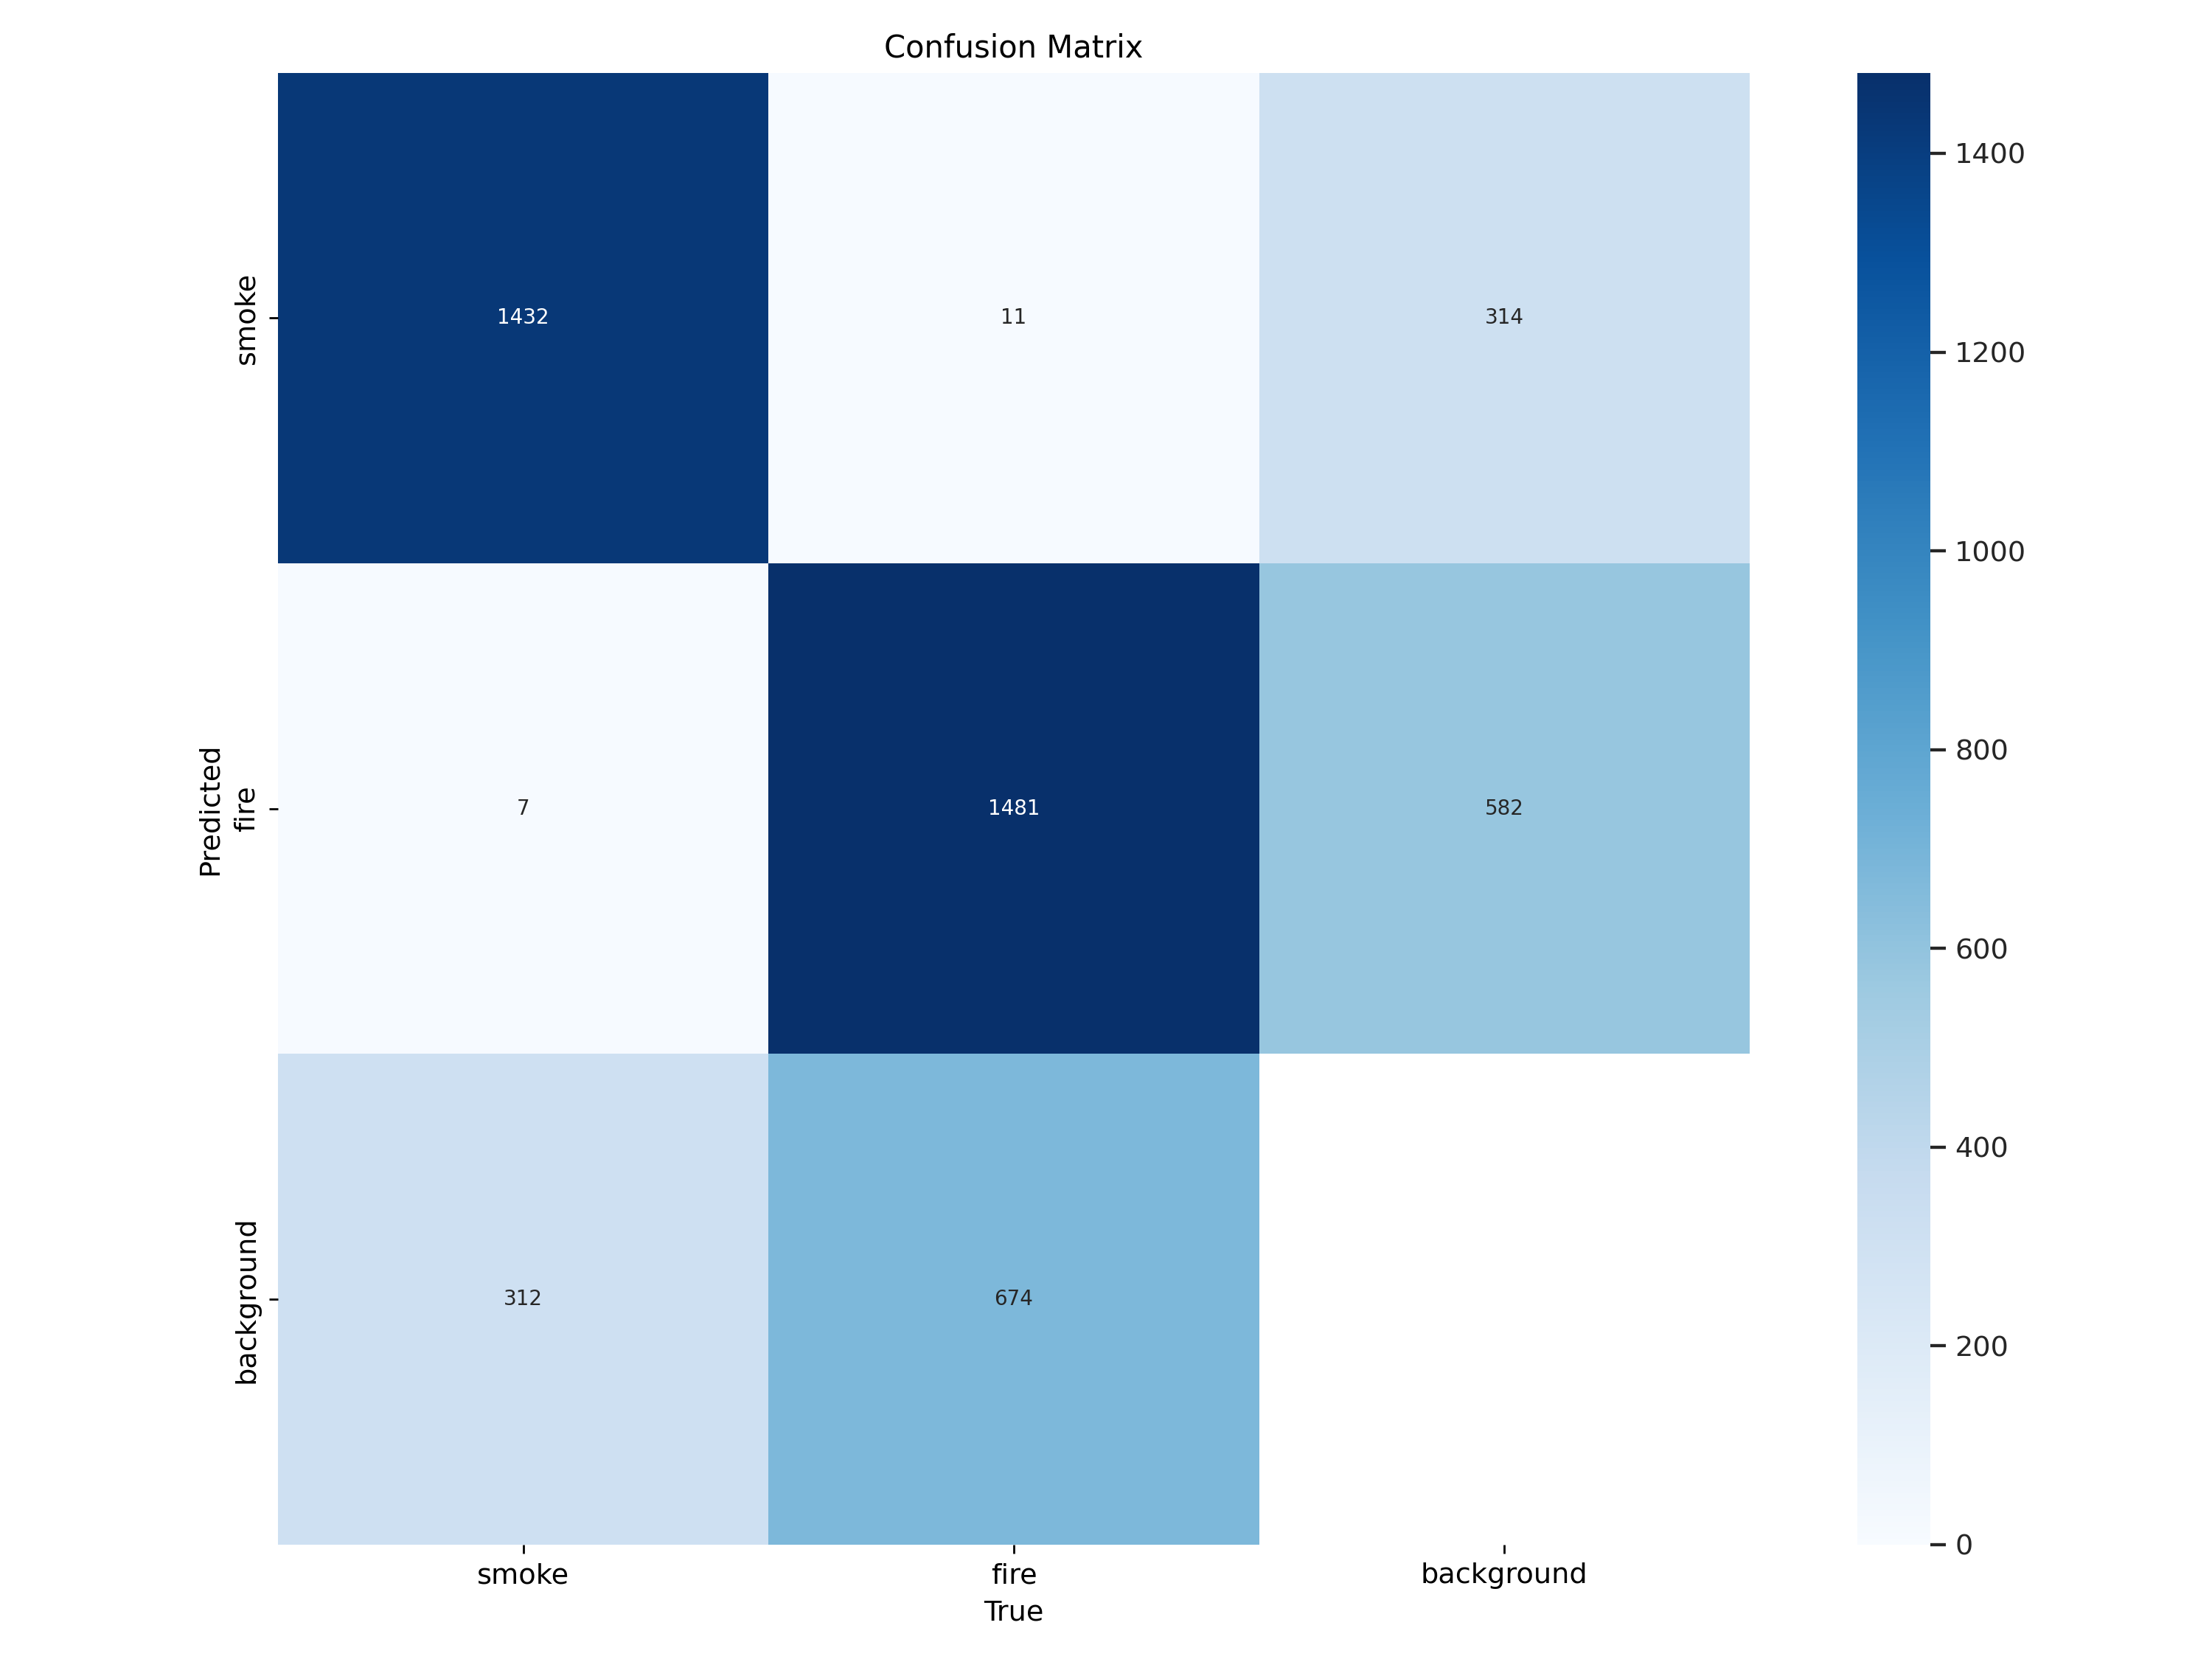

In [15]:
Image("/kaggle/working/runs/detect/train/confusion_matrix.png", width=600)

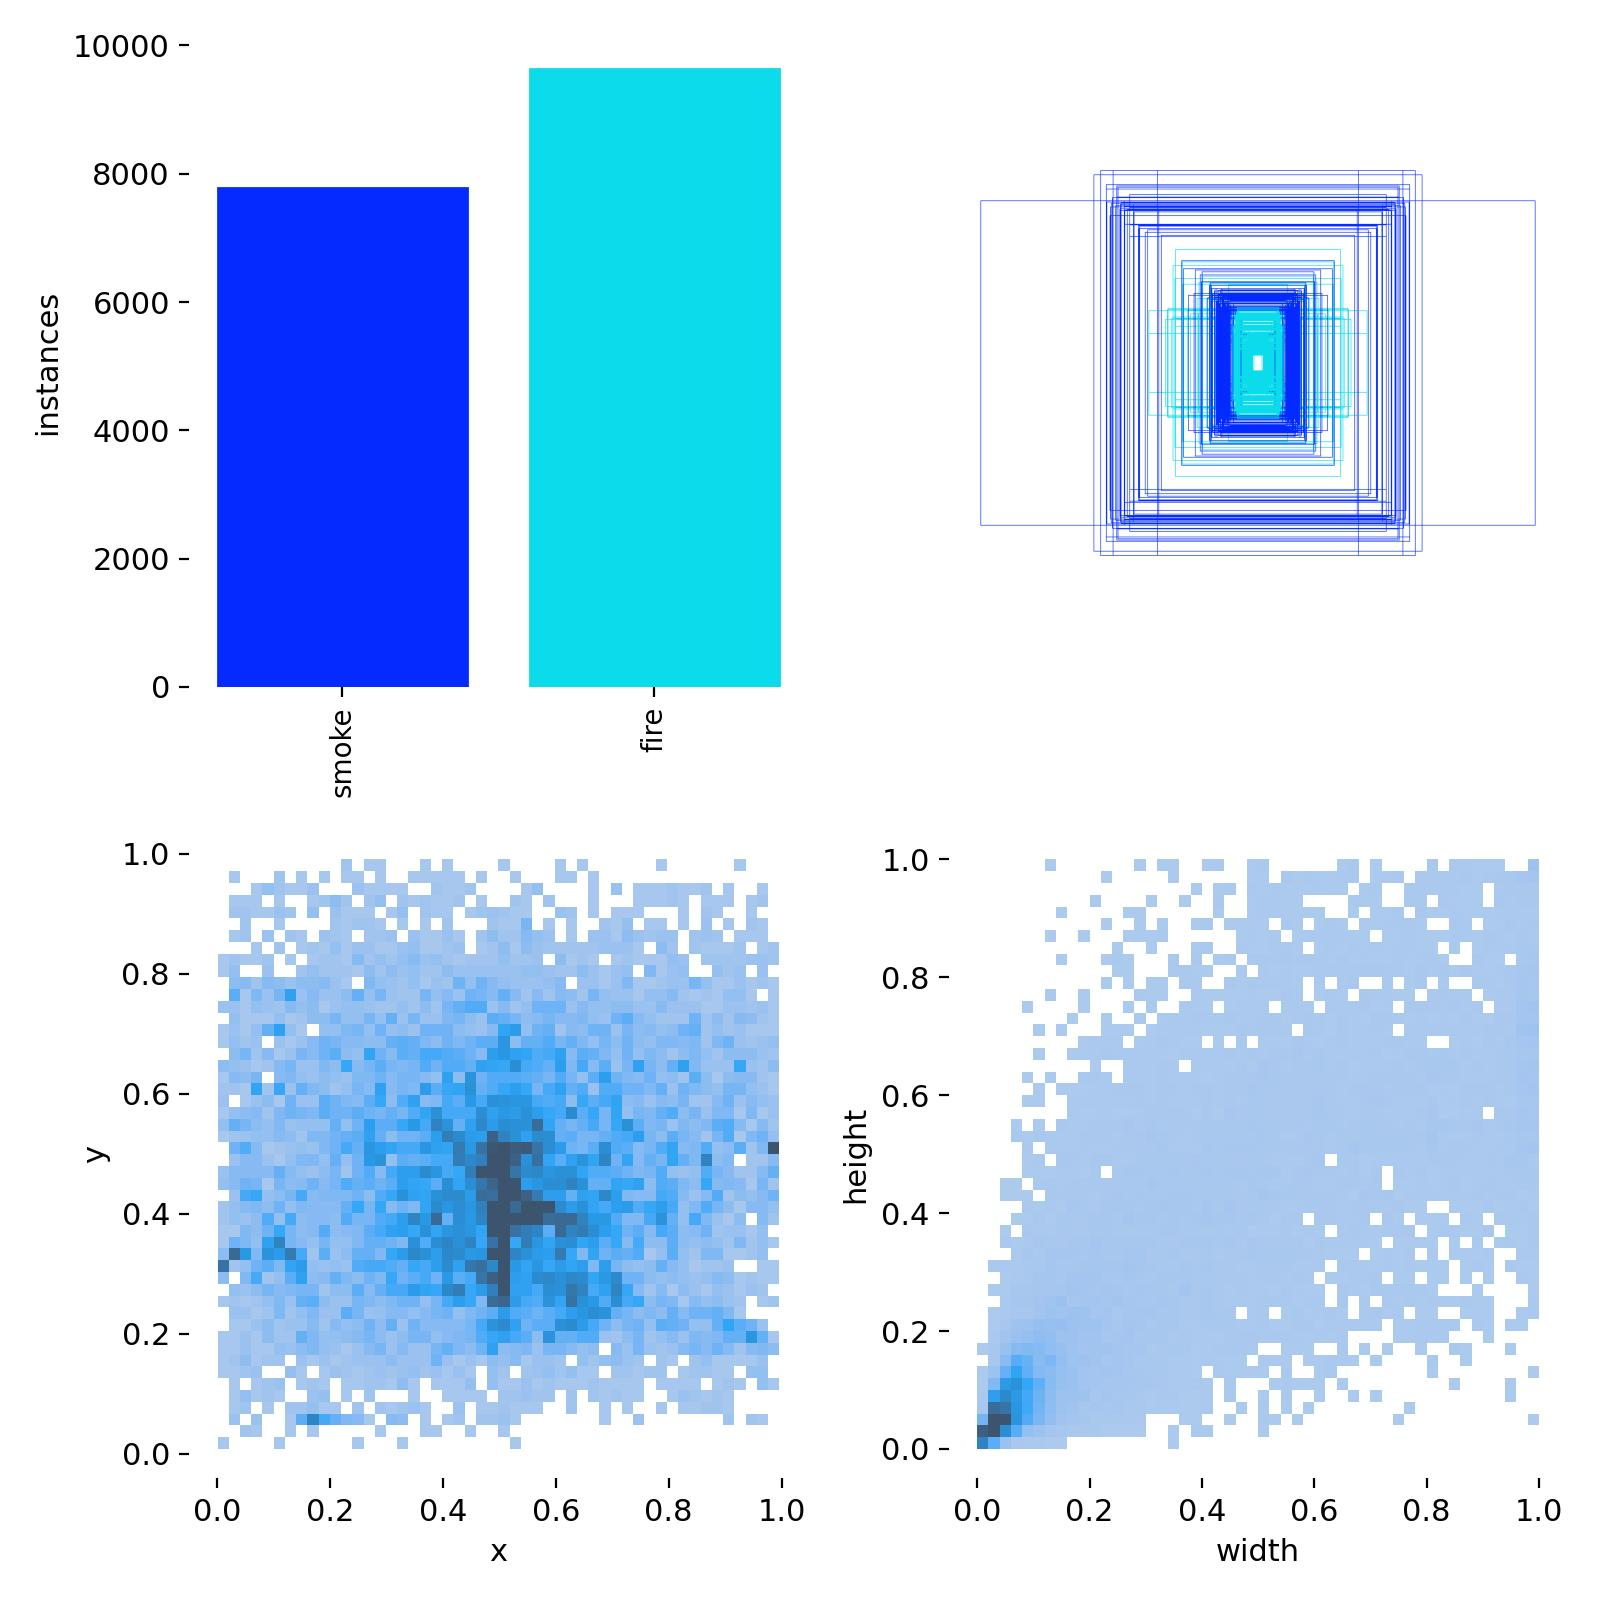

In [16]:
Image("/kaggle/working/runs/detect/train/labels.jpg", width=600)

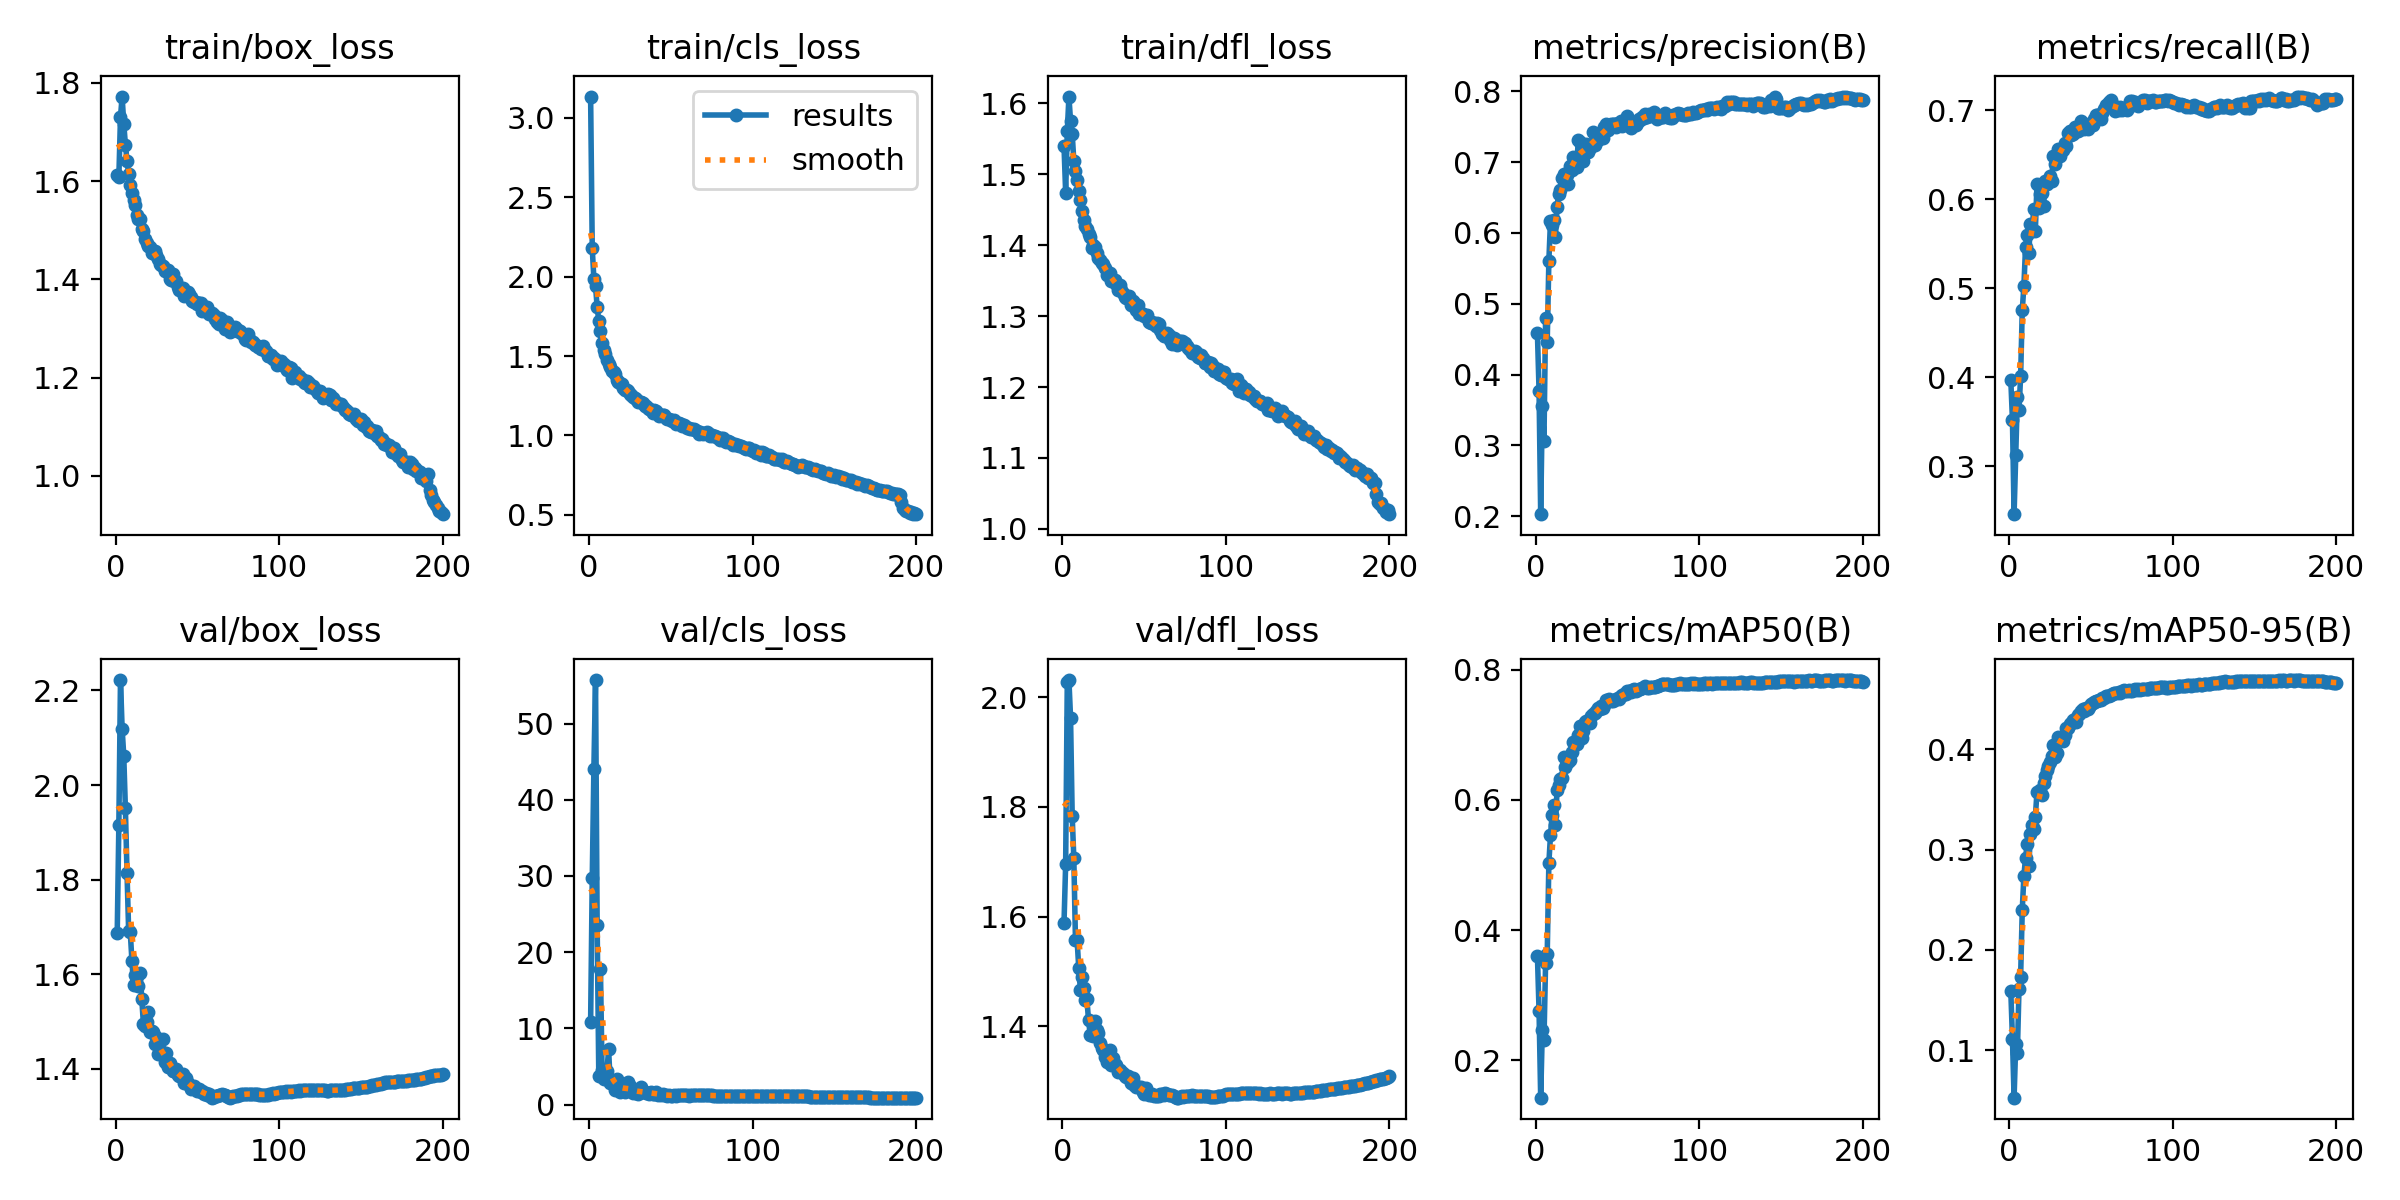

In [17]:
Image("/kaggle/working/runs/detect/train/results.png", width=600)

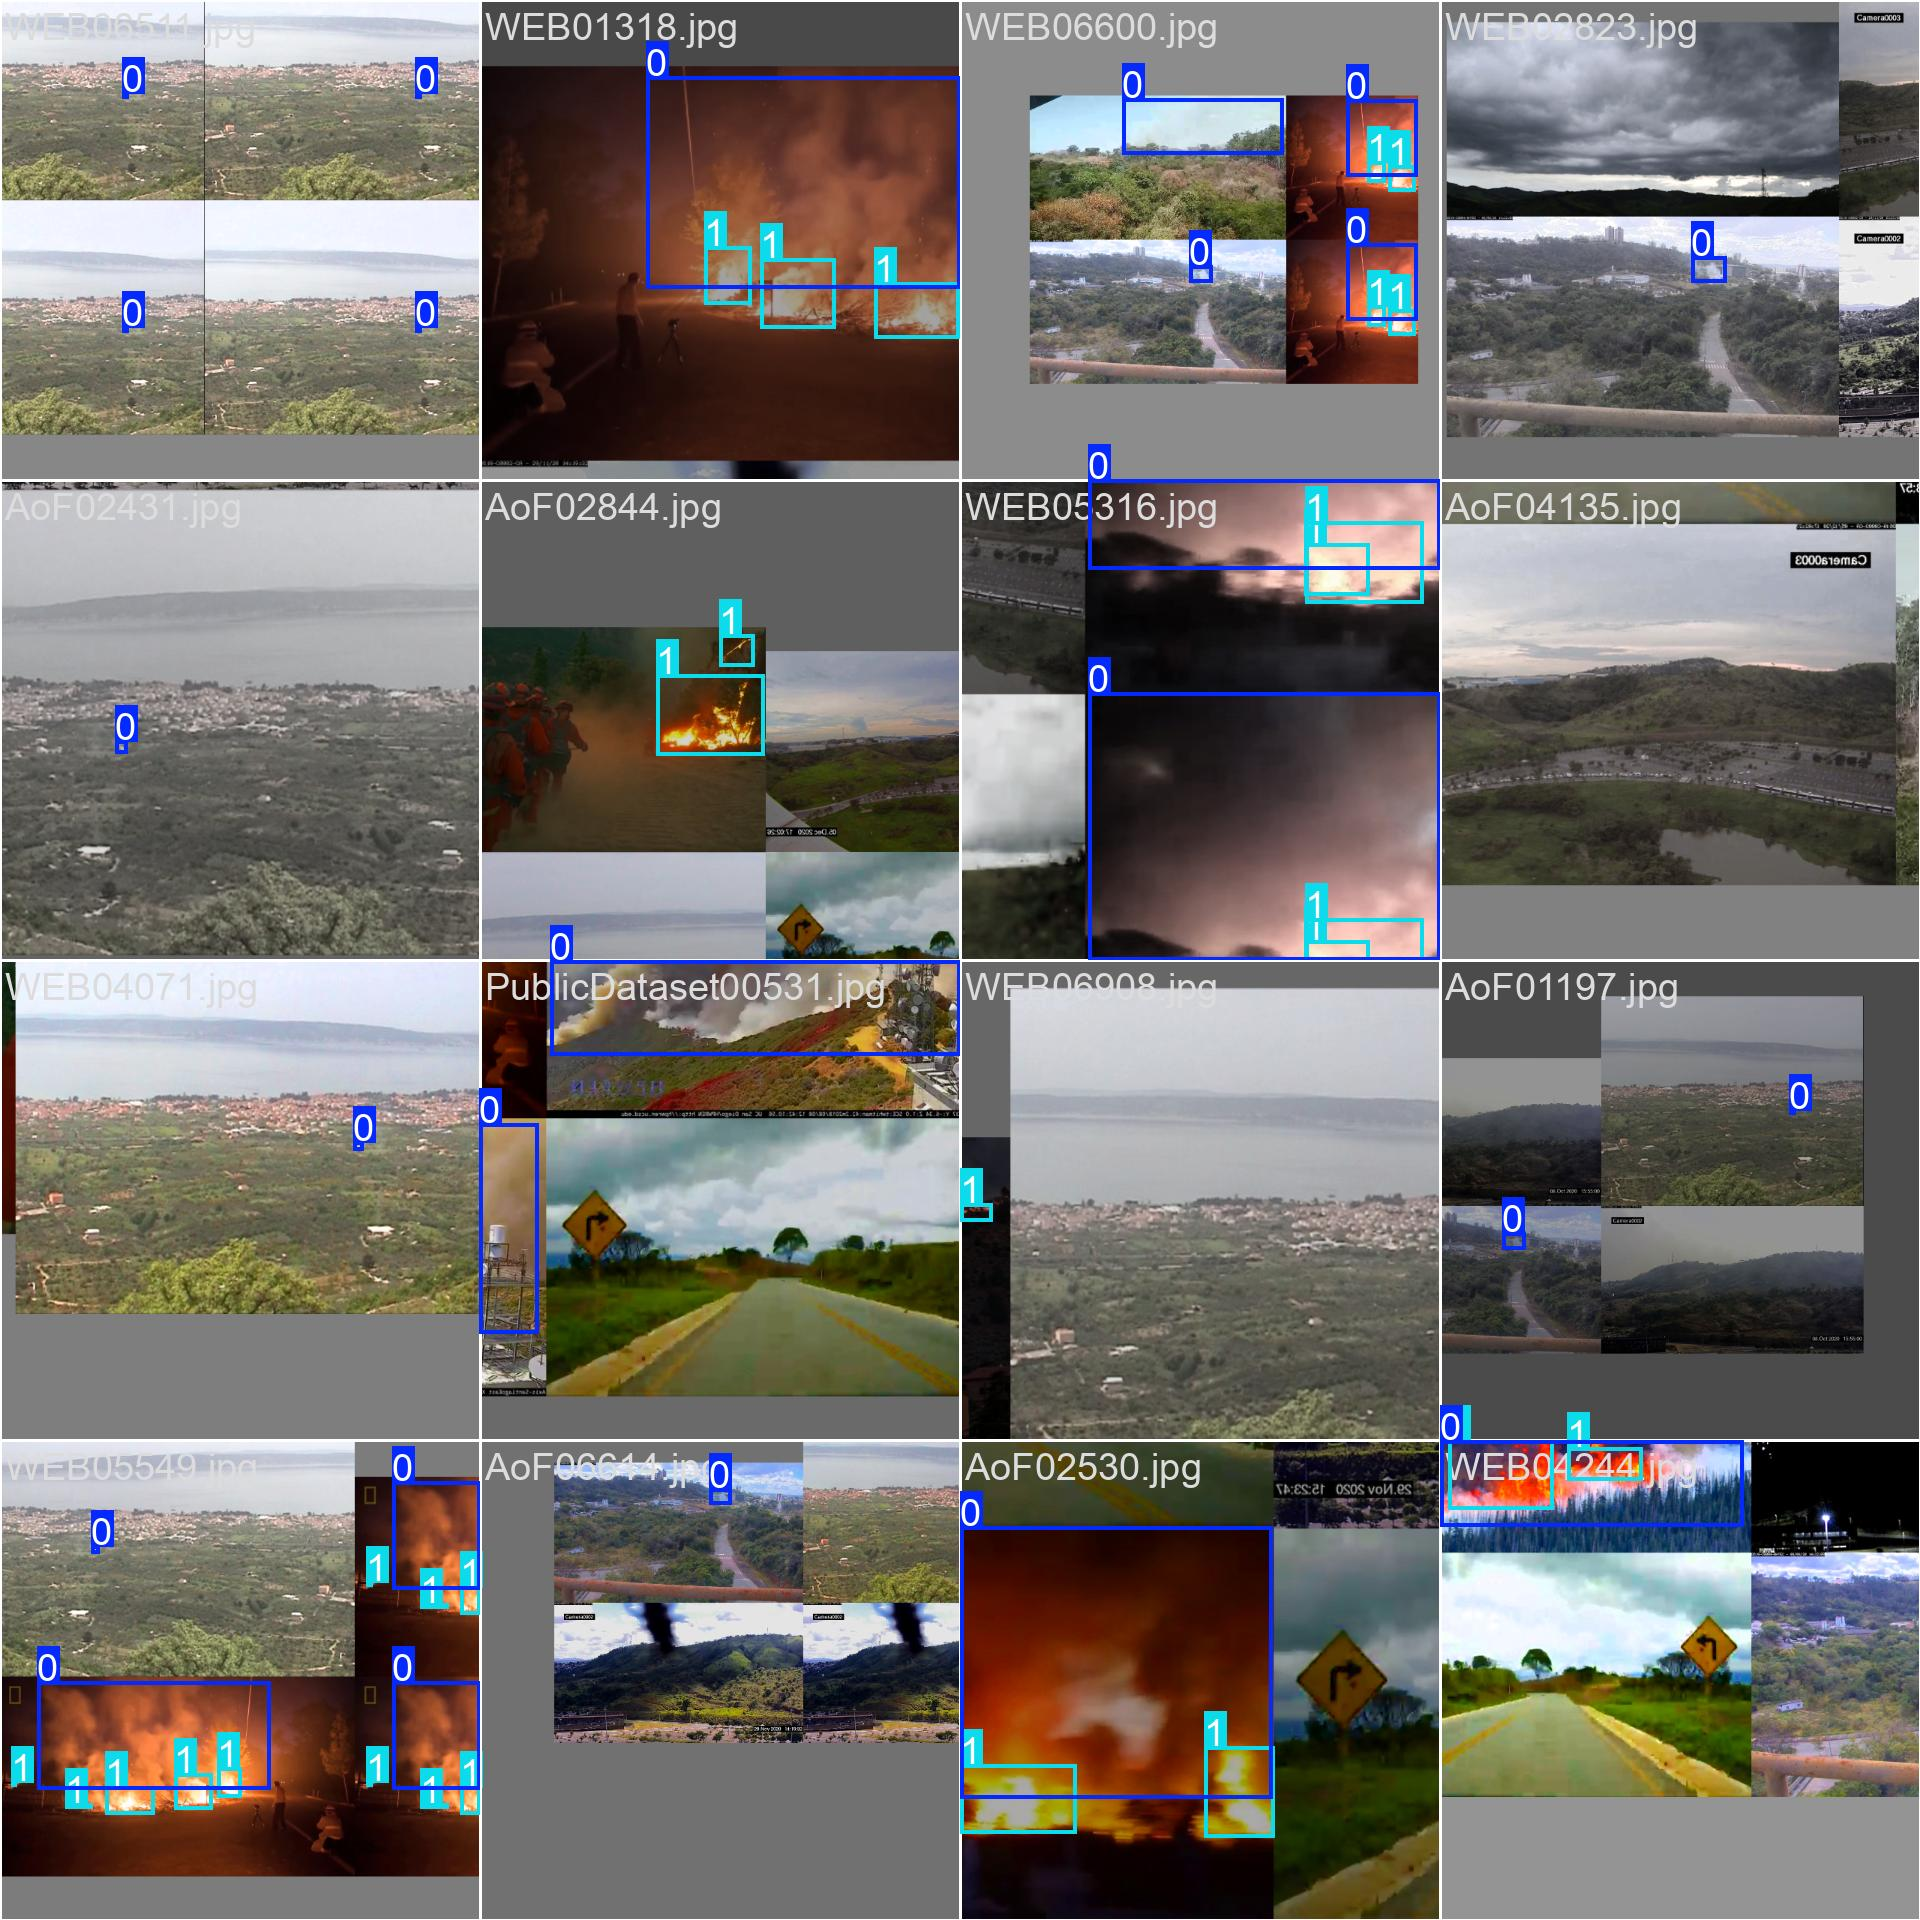

In [18]:
Image("/kaggle/working/runs/detect/train/train_batch0.jpg", width=600)

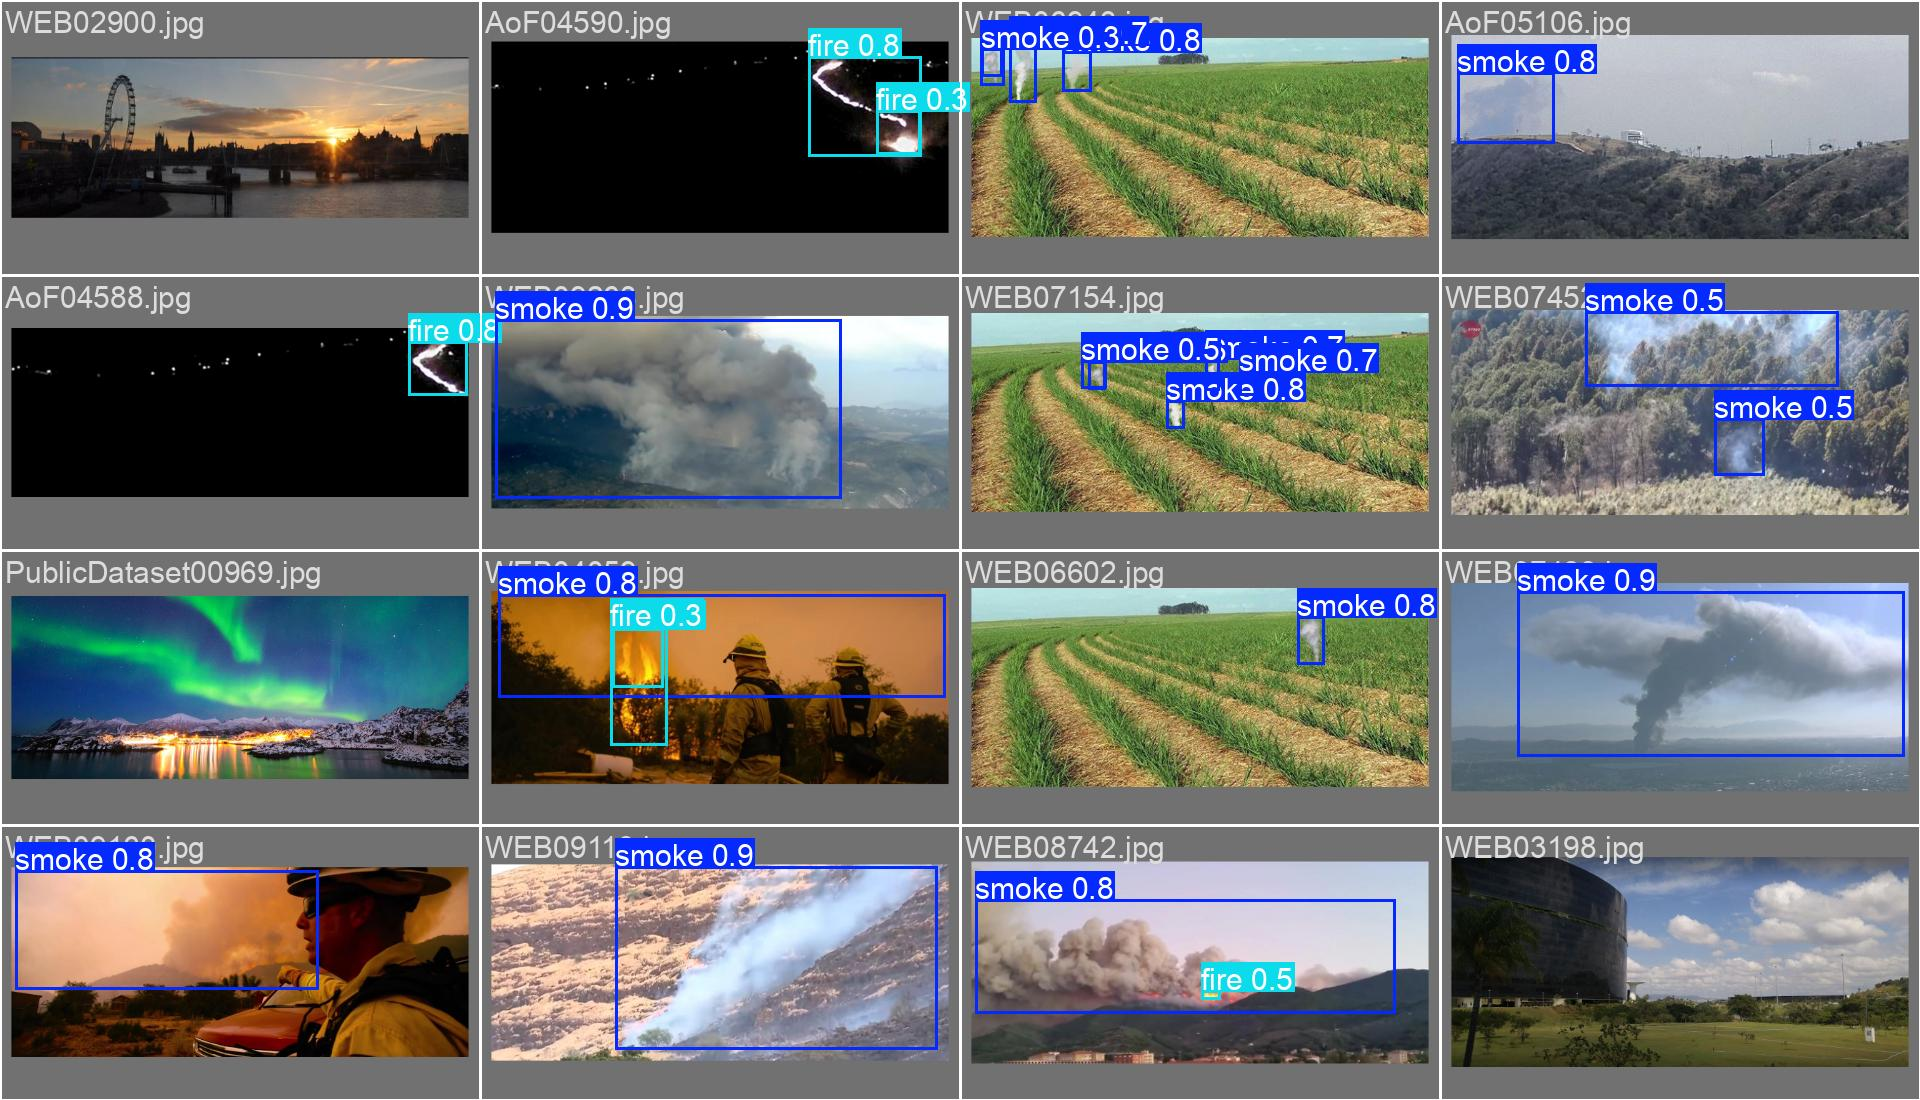

In [19]:
Image("/kaggle/working/runs/detect/train/val_batch0_pred.jpg", width=600)

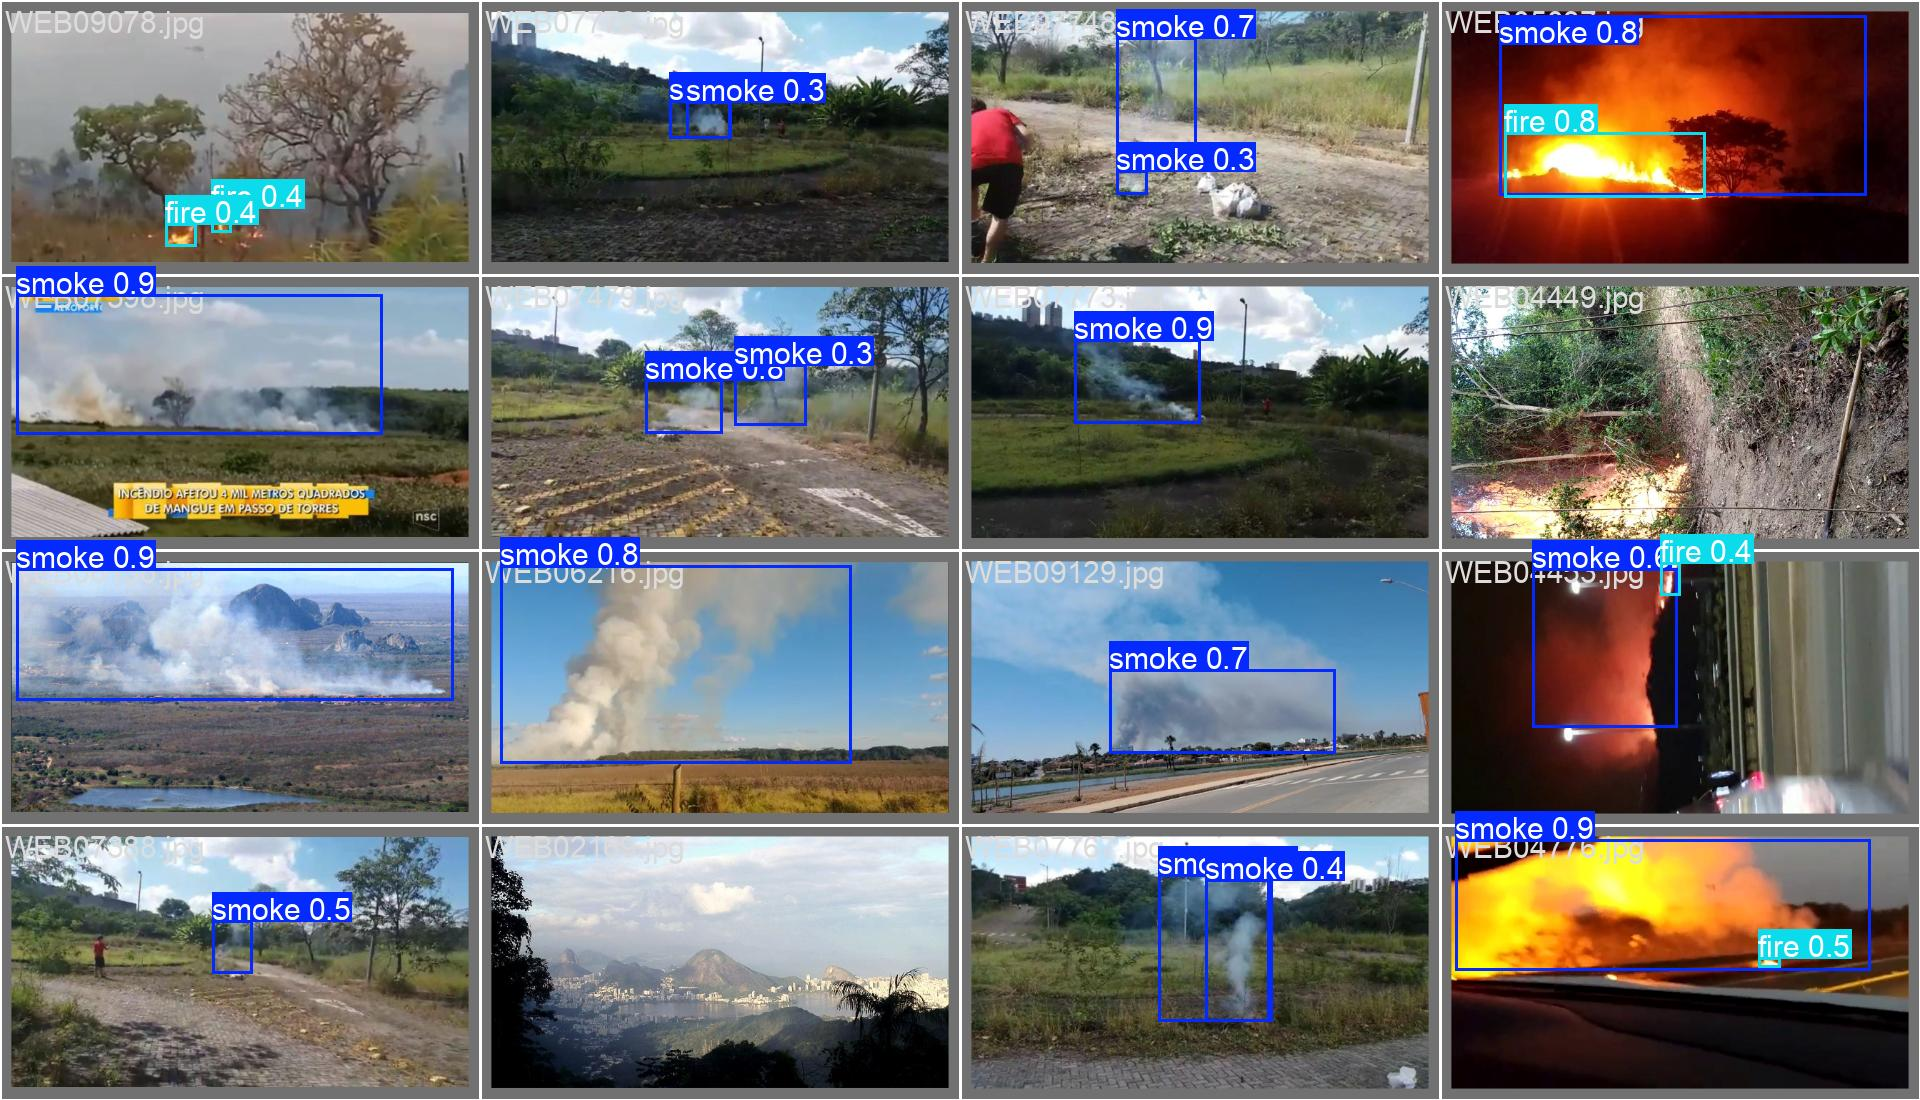

In [20]:
Image("/kaggle/working/runs/detect/train/val_batch1_pred.jpg", width=600)

In [21]:
!yolo task=detect mode=val model="/kaggle/working/runs/detect/train/weights/best.pt" data={output_path}

Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Scanning /kaggle/input/smoke-fire-detection-yolo/data/val/labels... 3094 im
val: WARNING ⚠️ /kaggle/input/smoke-fire-detection-yolo/data/val/images/WEB07535.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/smoke-fire-detection-yolo/data/val/images/WEB07535.jpg'
val: WARNING ⚠️ /kaggle/input/smoke-fire-detection-yolo/data/val/images/WEB07536.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/smoke-fire-detection-yolo/data/val/images/WEB07536.jpg'
val: WARNING ⚠️ /kaggle/input/smoke-fire-detection-yolo/data/val/images/WEB07539.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/smoke-fire-detection-yolo/data/val/images/WEB07539.jpg'
val: WARNING ⚠️ /kaggle/input/smoke-fire-detection-yolo/data/val/images/WEB075

In [26]:
!yolo task=detect mode=predict model="/kaggle/working/runs/detect/train/weights/best.pt" conf=0.25 source={root}/data/test/images save=True

Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs

image 1/1 /kaggle/input/xdxdxd/_2025-04-17_184012463.png: 320x640 1 smoke, 56.4ms
Speed: 5.4ms preprocess, 56.4ms inference, 190.9ms postprocess per image at shape (1, 3, 320, 640)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [31]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/kaggle/working/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[1:2]:
    display(IPyImage(filename=img, width=600))
    print("\n")